In [51]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import nltk
import netron

In [26]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/graysonlevy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/graysonlevy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:


def load_data(directory):
    texts = []
    labels = []
    indices = []  # To store the unique index from the filename

    for label_type in ['pos', 'neg']:
        dir_name = os.path.join(directory, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith(".txt"):
                # Extract index from filename
                index = int(fname.split('_')[0])
                with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                indices.append(f"{label_type}_{index}")  # Track the index and folder
                # Label: positive (1) or negative (0)
                if label_type == 'pos':
                    labels.append(1)
                else:
                    labels.append(0)
    return texts, labels, indices


# Define your directories
train_dir = 'train'  
test_dir = 'test'    

# Load train and test data
train_texts, train_labels, train_indices = load_data(train_dir)
test_texts, test_labels, test_indices = load_data(test_dir)

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


In [18]:
# self verify correct input
print(f"First few train indices: {train_indices[-5:]}")
print(f"First few train labels: {train_labels[-5:]}")
train_texts[-5:]

First few train indices: ['neg_3307', 'neg_2240', 'neg_11556', 'neg_4617', 'neg_9788']
First few train labels: [0 0 0 0 0]


['My comments may be a bit of a spoiler, for what it\'s worth. Stop now if you care enough....<br /><br />Saving Grace should have been titled "A Paper-Thin Excuse for Old British Women to Get High On-Screen." This film is dumb. The incidental music is an annoyance as are the obvious, hackneyed tunes that sporadically pop up to comment on the narrative ("Spirit in the Sky," for example - Oh, I get it!) This is basically a Cheech and Chong movie made credible by its stodgy English setting and Brenda Blethyn\'s overwhelming power to inflict emotion on an audience using her voice alone. I could literally hear the folks over at High Times magazine receiving their jollies over the enormous "buds" that litter this picture. Worst scene? Easy. Brenda attempts to peddle her illicit wares on the street of London in a blaring white dress-suit. Not funny. Not original. Not interesting. Not a good movie. The 7.2 rating is the result of zealots over-voting. Don\'t waste your time...',
 'The "saucy" 

In [27]:


stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply the text cleaning
train_texts = [clean_text(text) for text in train_texts]
test_texts = [clean_text(text) for text in test_texts]


In [29]:
train_texts[-5:]

['comments may bit spoiler worth stop care enoughbr br saving grace titled paperthin excuse old british women get high onscreen film dumb incidental music annoyance obvious hackneyed tunes sporadically pop comment narrative spirit sky example oh get basically cheech chong movie made credible stodgy english setting brenda blethyns overwhelming power inflict emotion audience using voice alone could literally hear folks high times magazine receiving jollies enormous buds litter picture worst scene easy brenda attempts peddle illicit wares street london blaring white dresssuit funny original interesting good movie 72 rating result zealots overvoting dont waste time',
 'saucy misadventures four au pairs arrive london day early 1970s theres swedish girl danish german chinese story contrives get clothes involve carry ontype humour couple various misfits british film tv culture time including man house star richard osullivan future coronation street rogue johnny briggs horror film stalwart fer

In [30]:
VOCAB_SIZE = 10000  
MAX_SEQUENCE_LENGTH = 200  

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad the sequences
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [78]:
model = Sequential()

# embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQUENCE_LENGTH))

# LSTM layer
model.add(LSTM(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# LSTM layer
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))

# Add dense output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history_ = model.fit(train_padded, train_labels, epochs=3, batch_size=32, validation_split=0.2)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/3
625/625 [==============================] - 113s 179ms/step - loss: 0.3932 - accuracy: 0.8213 - val_loss: 0.5147 - val_accuracy: 0.7920
Epoch 2/3
625/625 [==============================] - 111s 177ms/step - loss: 0.2223 - accuracy: 0.9144 - val_loss: 0.4392 - val_accuracy: 0.8170
Epoch 3/3
782/782 [==============================] - 19s 25ms/step - loss: 0.3690 - accuracy: 0.8582
Test Accuracy: 85.82%


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 200, 64)           640000    
                                                                 
 lstm_57 (LSTM)              (None, 200, 64)           33024     
                                                                 
 lstm_58 (LSTM)              (None, 32)                12416     
                                                                 
 dense_32 (Dense)            (None, 1)                 33        
                                                                 
Total params: 685,473
Trainable params: 685,473
Non-trainable params: 0
_________________________________________________________________
Serving 'model.keras' at http://localhost:19605


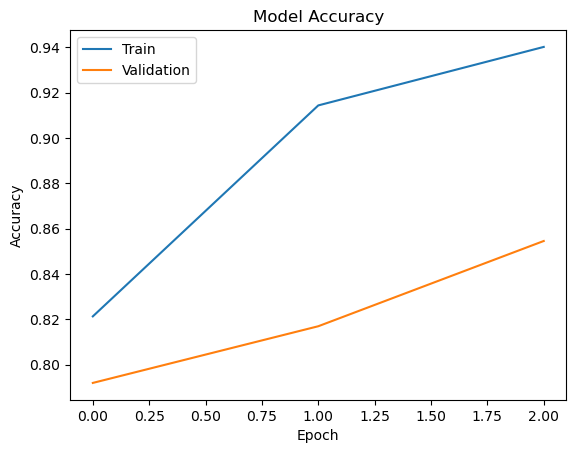

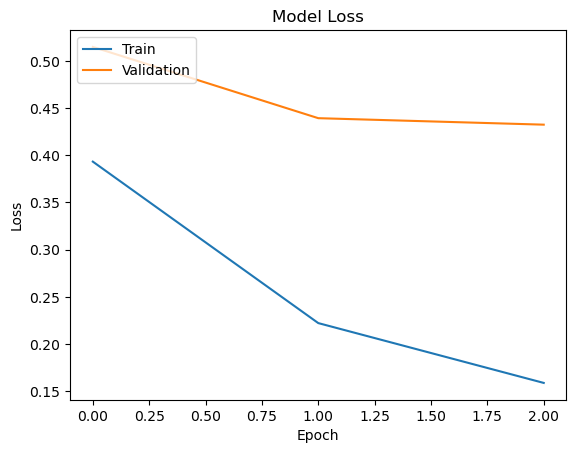

In [79]:
model.summary()
model.save('model.keras')
netron.start('model.keras')


# Plot accuracy
plt.plot(history_.history['accuracy'])
plt.plot(history_.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history_.history['loss'])
plt.plot(history_.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [80]:
from tensorflow.keras.regularizers import l2

model_1 = Sequential()

# Embedding layer
model_1.add(Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))

# First Bidirectional LSTM layer
model_1.add(Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))

# LSTM layer 
model_1.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))

model_1.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))

# Output layer for binary classification
model_1.add(Dense(1, activation='sigmoid'))


# Compile the model with Adam optimizer and a custom learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model_1.summary()

# Train the Model
history = model_1.fit(train_padded, train_labels, epochs=5, batch_size=128, validation_split=0.2)


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 200, 128)          1280000   
                                                                 
 bidirectional_23 (Bidirecti  (None, 200, 128)         98816     
 onal)                                                           
                                                                 
 lstm_60 (LSTM)              (None, 32)                20608     
                                                                 
 dense_33 (Dense)            (None, 32)                1056      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,400,513
Trainable params: 1,400,513
Non-trainable params: 0
___________________________________________

782/782 [==============================] - 44s 57ms/step - loss: 0.5140 - accuracy: 0.8539


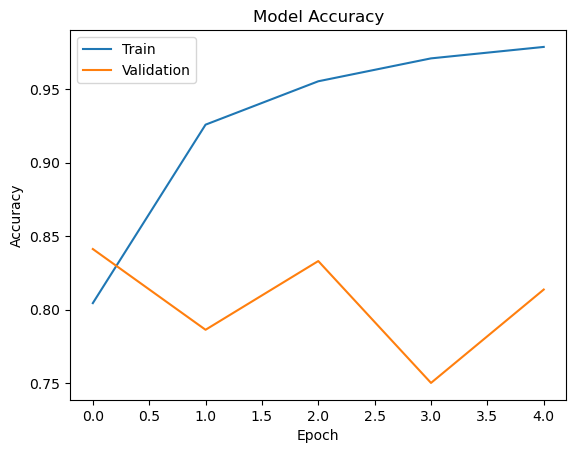

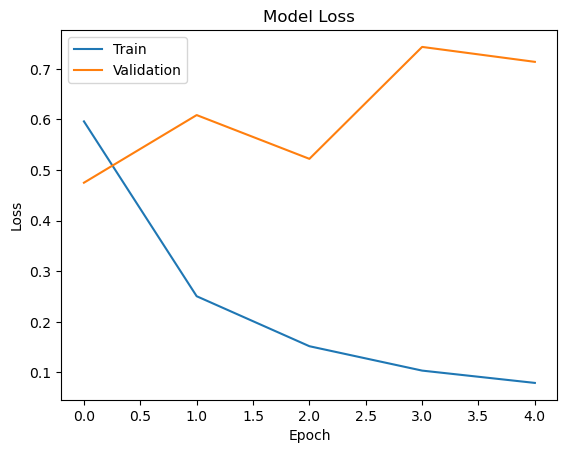

Test Accuracy: 85.39%


In [81]:
# Evaluate the Model
test_loss, test_accuracy = model_1.evaluate(test_padded, test_labels)
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [82]:
def evaluate_model(model, data_padded, data_labels, dataset_name="Dataset"):
    # Generate predictions (output probabilities)
    preds = model.predict(data_padded)
    
    # Convert probabilities to binary predictions (0 or 1)
    preds_binary = (preds > 0.5).astype(int)

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(data_labels, preds_binary)
    precision = precision_score(data_labels, preds_binary)
    recall = recall_score(data_labels, preds_binary)
    f1 = f1_score(data_labels, preds_binary)
    
    print(f"Metrics for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")
    
    return accuracy, precision, recall, f1

# Evaluate on training, validation, and test datasets for both models
print("---- Model 1 ----")
print("Training Set:")
evaluate_model(model, train_padded, train_labels, dataset_name="Training Set")

print("Test Set:")
evaluate_model(model, test_padded, test_labels, dataset_name="Test Set")


print("---- Model 2 ----")
print("Training Set:")
evaluate_model(model_1, train_padded, train_labels, dataset_name="Training Set")

print("Test Set:")
evaluate_model(model_1, test_padded, test_labels, dataset_name="Test Set")



---- Model 1 ----
Training Set:
782/782 [==============================] - 21s 27ms/step
Metrics for Training Set:
Accuracy: 0.9486, Precision: 0.9324, Recall: 0.9674, F1-Score: 0.9496

Test Set:
782/782 [==============================] - 21s 27ms/step
Metrics for Test Set:
Accuracy: 0.8582, Precision: 0.8576, Recall: 0.8589, F1-Score: 0.8583

---- Model 2 ----
Training Set:
782/782 [==============================] - 42s 54ms/step
Metrics for Training Set:
Accuracy: 0.9559, Precision: 0.9233, Recall: 0.9944, F1-Score: 0.9575

Test Set:
782/782 [==============================] - 44s 56ms/step
Metrics for Test Set:
Accuracy: 0.8539, Precision: 0.8272, Recall: 0.8947, F1-Score: 0.8596



(0.85392, 0.8272189349112427, 0.89472, 0.8596464258262875)